# 프로젝트 : 네이버 영화리뷰 감성분석 도전하기

## 1. 소스코드

### 1. 데이터 준비와 확인

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
import os

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### 2. 데이터로더 구성

 IMDB 데이터셋 숫자 인덱스로 변환된 텍스트와 word_to_index 딕셔너리까지 친절하게 제공   
    nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있음   
    imdb.data_loader()와 동일하게 동작하는 자신만의 data_loader를 만들어 보는 것으로 시작
    
    data_loader 안에서는 다음을 수행해야 합니다.

데이터의 중복 제거   
NaN 결측치 제거   
한국어 토크나이저로 토큰화   
불용어(Stopwords) 제거   
사전word_to_index 구성   
텍스트 스트링을 사전 인덱스 스트링으로 변환   
X_train, y_train, X_test, y_test, word_to_index 리턴   

In [2]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    # [[YOUR CODE]]
    
    # 데이터의 중복 제거 (drop_duplicates)
    # NaN 결측치 제거 (dropna)
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    # 한국어 토크나이저로 토큰화
    # 불용어(Stopwords) 제거
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    # 사전word_to_index 구성
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    #텍스트 스트링을 사전 인덱스 스트링으로 변환
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
    

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(train_data), len(test_data)))   

훈련 샘플 개수: 146183, 테스트 개수: 49158


In [3]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [4]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [5]:
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


In [6]:
print(X_train[0])  # 1번째 리뷰데이터
#텍스트 데이터가 아니라 이미 숫자로 encode된 텍스트 데이터를 다운로드받았음을 확인
#print(X_train.dtype)

print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


### 3. 모델구성을 위한 데이터 분석 및 가공

- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가


In [7]:
#data 는 인코딩된 형태임 즉 정수형
total_data_text = list(X_train) + list(X_test)

# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))


# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [8]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)
print(X_test.shape)

(146182, 41)
(49157, 41)


### 4. 모델구성 및 validation set 구성

- 모델은 3가지 이상 다양하게 구성하여 실험

In [9]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 15  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model = keras.Sequential()

#Embedding()에 넣어야하는 대표적인 인자
#첫번째 인자 = 단어 집합의 크기. 즉, 총 단어의 개수
#두번째 인자 = 임베딩 벡터의 출력 차원. 결과로서 나오는 임베딩 벡터의 크기
#input_length = 입력 시퀀스의 길이
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 15)          150000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 768       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 150,849
Trainable params: 150,849
Non-trainable params: 0
_________________________________________________________________


- validation set 구성

In [10]:
# validation set 10000건 분리
X_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


### 5. 모델 훈련 개시


In [11]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

#model.fit() 과정 중의 train/validation loss, accuracy 등이 매 epoch마다 history 변수에 저장
#이 데이터 그래프 가능
history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 6s 13ms/step - loss: 0.5933 - accuracy: 0.6883 - val_loss: 0.3622 - val_accuracy: 0.8386
Epoch 2/20
266/266 [==============================] - 3s 10ms/step - loss: 0.3368 - accuracy: 0.8582 - val_loss: 0.3468 - val_accuracy: 0.8501
Epoch 3/20
266/266 [==============================] - 3s 10ms/step - loss: 0.3125 - accuracy: 0.8699 - val_loss: 0.3436 - val_accuracy: 0.8487
Epoch 4/20
266/266 [==============================] - 3s 10ms/step - loss: 0.3067 - accuracy: 0.8729 - val_loss: 0.3450 - val_accuracy: 0.8488
Epoch 5/20
266/266 [==============================] - 3s 9ms/step - loss: 0.2975 - accuracy: 0.8758 - val_loss: 0.3452 - val_accuracy: 0.8499
Epoch 6/20
266/266 [==============================] - 3s 10ms/step - loss: 0.2876 - accuracy: 0.8806 - val_loss: 0.3420 - val_accuracy: 0.8536
Epoch 7/20
266/266 [==============================] - 3s 10ms/step - loss: 0.2803 - accuracy: 0.8831 - val_loss: 0.3436 - val_accuracy: 0.8544


In [12]:
results = model.evaluate(X_test,  y_test, verbose=1)

print(results)

1537/1537 [==============================] - 5s 4ms/step - loss: 0.4829 - accuracy: 0.8420
[0.482870489358902, 0.8419960737228394]


### 6. Loss, Accuracy 그래프 시각화


In [13]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


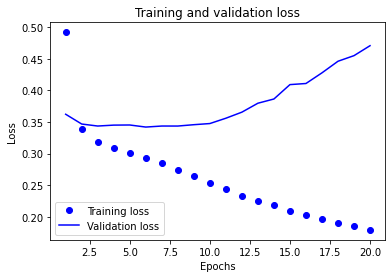

In [14]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

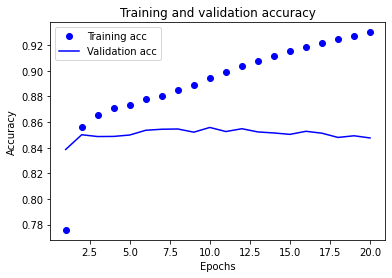

In [15]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#####  (두번째 모델)
- 텍스트를 처리하기 위해 RNN이 아니라 1-D Convolution Neural Network(1-D CNN)를 사용

In [16]:
vocab_size = 10  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 4   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 4)           40        
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          464       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [19]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

#model.fit() 과정 중의 train/validation loss, accuracy 등이 매 epoch마다 history 변수에 저장
#이 데이터 그래프 가능
history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

results = model.evaluate(X_test,  y_test, verbose=1)

print(results)

Epoch 1/20


InvalidArgumentError: 2 root error(s) found.
  (0) Invalid argument:  indices[448,30] = 239 is not in [0, 10)
	 [[node sequential_1/embedding_1/embedding_lookup (defined at <ipython-input-19-e0b8e4f6ee61>:14) ]]
	 [[sequential_1/embedding_1/embedding_lookup/_20]]
  (1) Invalid argument:  indices[448,30] = 239 is not in [0, 10)
	 [[node sequential_1/embedding_1/embedding_lookup (defined at <ipython-input-19-e0b8e4f6ee61>:14) ]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_21669]

Errors may have originated from an input operation.
Input Source operations connected to node sequential_1/embedding_1/embedding_lookup:
 sequential_1/embedding_1/embedding_lookup/21296 (defined at /opt/conda/lib/python3.7/contextlib.py:112)

Input Source operations connected to node sequential_1/embedding_1/embedding_lookup:
 sequential_1/embedding_1/embedding_lookup/21296 (defined at /opt/conda/lib/python3.7/contextlib.py:112)

Function call stack:
train_function -> train_function


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


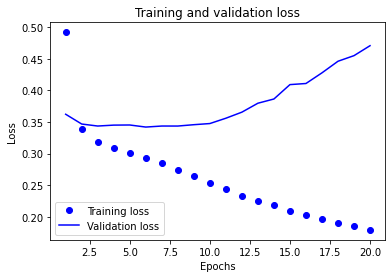

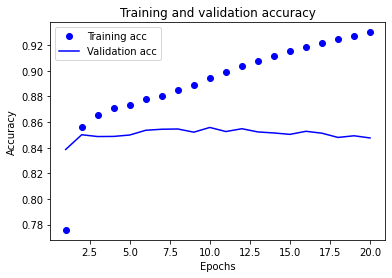

In [20]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

#plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#####  (세번째 모델)
- GlobalMaxPooling1D() 레이어 하나만 사용하는 방법도 생각,   
전체 문장 중에서 단 하나의 가장 중요한 단어만 피처로 추출하여 그것으로 문장의 긍정/부정을 평가하는 방식

In [21]:
vocab_size = 10  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 4   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 4)           40        
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 4)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

#model.fit() 과정 중의 train/validation loss, accuracy 등이 매 epoch마다 history 변수에 저장
#이 데이터 그래프 가능
history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

results = model.evaluate(X_test,  y_test, verbose=1)

print(results)

Epoch 1/20


InvalidArgumentError: 2 root error(s) found.
  (0) Invalid argument:  indices[448,29] = 446 is not in [0, 10)
	 [[node sequential_2/embedding_2/embedding_lookup (defined at <ipython-input-22-e0b8e4f6ee61>:14) ]]
	 [[sequential_2/embedding_2/embedding_lookup/_20]]
  (1) Invalid argument:  indices[448,29] = 446 is not in [0, 10)
	 [[node sequential_2/embedding_2/embedding_lookup (defined at <ipython-input-22-e0b8e4f6ee61>:14) ]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_22525]

Errors may have originated from an input operation.
Input Source operations connected to node sequential_2/embedding_2/embedding_lookup:
 sequential_2/embedding_2/embedding_lookup/22221 (defined at /opt/conda/lib/python3.7/contextlib.py:112)

Input Source operations connected to node sequential_2/embedding_2/embedding_lookup:
 sequential_2/embedding_2/embedding_lookup/22221 (defined at /opt/conda/lib/python3.7/contextlib.py:112)

Function call stack:
train_function -> train_function


In [ ]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

#plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 7. 학습된 Embedding 레이어 분석

In [46]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 200)


In [47]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/Kword2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [48]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['추천']
vector

array([-0.3063027 , -0.9484563 ,  1.2492388 , -1.5927795 ,  0.40691626,
       -0.8505893 , -0.98781914,  0.32936776, -1.1299601 , -0.592702  ,
        0.57233   , -0.64542323,  1.7229025 , -0.89875376, -0.6503911 ,
       -0.40962842, -0.55270594, -1.5752168 ,  0.18231687, -0.43748972,
        0.46901628, -0.77352625, -1.3367366 ,  0.6120526 ,  0.77523494,
       -0.5522236 , -1.5403827 , -1.2579628 , -0.10295826, -0.10291309,
       -0.6422332 , -0.6783376 ,  1.2362761 , -0.73503995, -0.14372458,
        1.0994352 ,  1.1318715 , -0.14686152, -0.98535687, -0.3865985 ,
       -0.1824299 , -0.5877441 , -0.08886398, -1.6173553 , -0.35177806,
        0.49891236,  1.373031  , -0.28662968,  1.3665999 ,  0.34908587,
       -1.1204977 , -1.3482653 , -0.7447265 ,  3.3176541 ,  0.30507126,
       -1.6661406 ,  3.1609986 ,  0.5574424 , -0.6197897 , -0.13826768,
       -0.02826177, -0.46438324, -1.4113654 , -0.3196419 ,  0.77045417,
       -0.6145871 , -1.2215601 ,  0.4621315 , -0.56117165, -0.90

In [49]:
word_vectors.similar_by_word("행복")

[('사랑', 0.6459413766860962),
 ('기쁨', 0.6209545135498047),
 ('삶', 0.5961189270019531),
 ('평등', 0.55022132396698),
 ('욕망', 0.5450345277786255),
 ('쾌락', 0.5423295497894287),
 ('인생', 0.5381695032119751),
 ('즐겁', 0.5370572209358215),
 ('즐거움', 0.5355871915817261),
 ('고독', 0.5315930843353271)]

### 8. 한국어 Word2Vec 임베딩 활용하여 성능개선

In [50]:
from gensim.models import KeyedVectors
import gensim

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'

# KeyedVectors.load_word2vec_format 메소드로 워드 벡터를 로딩할 때 가장 많이 사용되는 상위 100만 개만 limt으로 조건을 주어 로딩
# 메모리가 충분하다면 limt=None으로 하시면 300만 개를 모두 로딩

word2vec = gensim.models.Word2Vec.load(word2vec_path)

vector = word2vec.wv.most_similar("강아지")
vector

word2vec['강아지'].shape

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


(200,)

In [51]:
vector

[('고양이', 0.7290452718734741),
 ('거위', 0.7185635566711426),
 ('토끼', 0.7056223154067993),
 ('멧돼지', 0.6950401067733765),
 ('엄마', 0.6934334635734558),
 ('난쟁이', 0.6806551218032837),
 ('한마리', 0.6770296096801758),
 ('아가씨', 0.6750352382659912),
 ('아빠', 0.6729634404182434),
 ('목걸이', 0.6512460708618164)]

In [52]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [55]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원 수 

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 35, 16)            22416     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

In [56]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=1024,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
133/133 [==============================] - 14s 75ms/step - loss: 0.6481 - accuracy: 0.5997 - val_loss: 0.4757 - val_accuracy: 0.7706
Epoch 2/20
133/133 [==============================] - 6s 42ms/step - loss: 0.4395 - accuracy: 0.7966 - val_loss: 0.3982 - val_accuracy: 0.8240
Epoch 3/20
133/133 [==============================] - 6s 42ms/step - loss: 0.3611 - accuracy: 0.8420 - val_loss: 0.3623 - val_accuracy: 0.8393
Epoch 4/20
133/133 [==============================] - 5s 41ms/step - loss: 0.3205 - accuracy: 0.8636 - val_loss: 0.3521 - val_accuracy: 0.8444
Epoch 5/20
133/133 [==============================] - 6s 42ms/step - loss: 0.2863 - accuracy: 0.8813 - val_loss: 0.3472 - val_accuracy: 0.8475
Epoch 6/20
133/133 [==============================] - 5s 41ms/step - loss: 0.2659 - accuracy: 0.8907 - val_loss: 0.3545 - val_accuracy: 0.8476
Epoch 7/20
133/133 [==============================] - 6s 42ms/step - loss: 0.2474 - accuracy: 0.9003 - val_loss: 0.3631 - val_accuracy: 0.847

- 에포크 20 = 0.8277
- 에포크 5 = 0.8259
- 에포크 5 / 배치사이즈 256 = 0.8261
- 에포크 20 / 배치사이즈 128 = 0.8276


In [43]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 1.4612 - accuracy: 0.8276
[1.4612462520599365, 0.8275728821754456]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


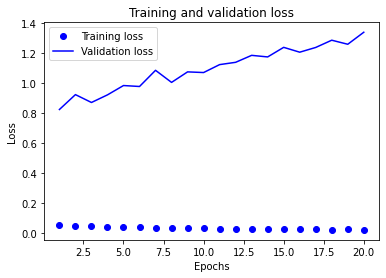

In [44]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

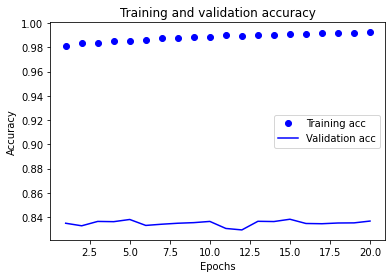

In [45]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 2. 회고

#### 1. 과정

- (1) 데이터 로더 구성과 관련
   사전word_to_index 구성과 관련해서 LMS상에 있는 소스코드를 그대로 들고와서, 사전word_to_index 구성의 4가지  PAD, BOS, UNK, UNUSED 간과했다. 그 결과 **패딩추가**는 물론이고, **validation** 세팅도 되지않았다. 다음부터는 무작정 복사붙여넣기를 지양해야지
   
- (2) 한국어 Word2Vec 임베딩 활용 관련
    pip install --upgrade gensim==3.8.3 를 통해서 gensim의 버젼을 낮춰야지 한국어 Word2Vec 임베딩 활용이 가능했다.


#### 2. 배운점

- (1) 워드임베딩 기법은 많은 사람들이 서로간의 도움을 많이 필요로 하게될 영역이라고 보인다. 특히 영어 위주인 국내 자연어처리 분야에는 반드시 해결해야할 문제라고 생각한다.

- (2) RNN은 이전 상태의 것이 계속해서 가지고있을 수 있다는 것을 알게되었다. 


#### 3. 마치며

- 점점 실용적으로 하고싶은 분야들을 하게된다. 흥미롭다.